In [2]:
import json
import torch
import torch.nn as nn
import torch.utils.data
import math
import torch.nn.functional as F
import neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from collections import Counter
from torchinfo import summary
from sklearn.decomposition import PCA
from torch.utils.data import Dataset

In [3]:
# knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom.xlsx'
knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_simple.xlsx'
knowledgebase_url_test = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_eval.xlsx'
knowledgebase = pd.read_excel(knowledgebase_url)

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan','Jawaban']))
# qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Labels' ,'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,visi filkom,menjadi fakultas yang berdaya saing internasio...
1,misi filkom,menyelenggarakan pendidikan di bidang teknolog...
2,apa tujuan filkom?,"menghasilkan lulusan yang kompeten , profesion..."
3,sasaran pendidikan filkom,meningkatkan kompetensi dan kualifikasi pendid...
4,email fitra a. bachtiar,fitra.bachtiar[at]ub.ac.id
5,bidang penelitian fitra a. bachtiar,"affective computing, affective engineering, in..."
6,tanggal dibentuk ptiik,27 oktober 2011
7,sasaran pengabdian filkom,1. meningkatkan kualitas dan kuantitas pengabd...
8,sasaran kerjasama filkom,"1. mengadakan kerjasama pendidikan, penlitian ..."
9,dekan fakultas ilmu komputer filkom,"prof. ir. wayan firdaus mahmudy, s.si., mt., p..."


In [4]:
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  # space is also a character
    return no_punct.lower()

In [5]:
pairs = []
max_len = 90

for line in qa_paired.iterrows():
    pertanyaan = line[1]['Pertanyaan']
    jawaban = line[1]['Jawaban']
    qa_pairs = []
    first = remove_punc(pertanyaan.strip())      
    second = remove_punc(jawaban.strip())

    if len(first) == 0 or len(second) == 0:
        continue

    
    qa_pairs.append(first.split()[:max_len])
    qa_pairs.append(second.split()[:max_len])
    pairs.append(qa_pairs)

In [6]:
pairs_df = pd.DataFrame(pairs, columns=['question', 'answer'])
pairs_df

,question,answer
0,"[visi, filkom]","[menjadi, fakultas, yang, berdaya, saing, inte..."
1,"[misi, filkom]","[menyelenggarakan, pendidikan, di, bidang, tek..."
2,"[apa, tujuan, filkom]","[menghasilkan, lulusan, yang, kompeten, profes..."
3,"[sasaran, pendidikan, filkom]","[meningkatkan, kompetensi, dan, kualifikasi, p..."
4,"[email, fitra, a, bachtiar]",[fitrabachtiaratubacid]
5,"[bidang, penelitian, fitra, a, bachtiar]","[affective, computing, affective, engineering,..."
6,"[tanggal, dibentuk, ptiik]","[27, oktober, 2011]"
7,"[sasaran, pengabdian, filkom]","[1, meningkatkan, kualitas, dan, kuantitas, pe..."
8,"[sasaran, kerjasama, filkom]","[1, mengadakan, kerjasama, pendidikan, penliti..."
9,"[dekan, fakultas, ilmu, komputer, filkom]","[prof, ir, wayan, firdaus, mahmudy, ssi, mt, phd]"


In [7]:
word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

In [8]:
min_word_freq = 0
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

In [9]:
print("Total words are: {}".format(len(word_map)))

Total words are: 449


In [10]:
with open('WORDMAP_corpus_KBFILKOM.json', 'w') as j:
    json.dump(word_map, j)

In [11]:
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c


def encode_question_left(words, word_map):
    enc_c = [word_map['<pad>']] * (max_len - len(words)) + [word_map.get(word, word_map['<unk>']) for word in words]
    return enc_c

def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply_with_maxlen(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<end>']] + [word_map['<pad>']] * (max_len-2 - len(words))
    return enc_c

In [12]:
pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    # qus = encode_question_left(pair[0], word_map)
    ans = encode_reply(pair[1], word_map)
    pairs_encoded.append([qus, ans])

with open('pairs_encoded_kbfilkom.json', 'w') as p:
    json.dump(pairs_encoded, p)

In [13]:
class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded_kbfilkom.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

## Train Loader

In [14]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100, 
                                           shuffle=True, 
                                           pin_memory=True)

In [15]:
def create_masks(question, reply_input, reply_target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)
    
    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
    return question_mask, reply_input_mask, reply_target_mask

In [16]:
import os

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory created at {path}")
    else:
        print(f"Directory already exists at {path}")

# Architecture

## Embeddings

In [17]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model, max_len = 50, num_layers = 6):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe
        
    def forward(self, embedding, layer_idx):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        # embedding: (batch_size, max_len, d_model), te: (batch_size, 1, d_model)
        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)
        embedding = self.dropout(embedding)
        return embedding

## Multi-Head Attention

In [18]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, heads, d_model):
        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted 

## Feed Forward Neural Network

In [19]:
class FeedForward(nn.Module):
    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out


## Encoder

In [20]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

## Decoder

In [21]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded


## Transformer Architecture

In [22]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers_enc, num_layers_dec, word_map, max_len = 50):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.vocab_size = len(word_map)
        self.embed_enc = Embeddings(self.vocab_size, d_model, num_layers = num_layers_enc, max_len = max_len)
        self.embed_dec = Embeddings(self.vocab_size, d_model, num_layers = num_layers_dec, max_len = max_len)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers_enc):
            src_embeddings = self.embed_enc(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers_enc):
            tgt_embeddings = self.embed_enc(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out


In [23]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()       
        

In [24]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size
        
    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss
        

# Define Neptune Experiment

In [98]:
project = "andialifs/siet-24"
api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTY2YWQ3My04OTBkLTQ2OWUtYTc1Ni1jYjk0MGZhMWFiNGEifQ=="

def neptune_init(name):
    run = neptune.init_run(
        project=project,
        api_token=api_token,
        name=name
    )
    return run

# Function

## Train

In [25]:
def train(train_loader, transformer, criterion, epoch):
    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):
        
        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)
        
        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))
    
    return sum_loss/count

## Evaluate

In [26]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)
    
    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)
        
    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()
        
    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])
    
    return sentence

In [27]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    bleu_score_all = 0

    num_of_rows_calculated = 0

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        # print(f"Question: {question}")
        # print(f"Real Answer: {real_answer}")
        # print(f"Predicted Answer: {preds[i]}")
        try:
            refs = [real_answer.split(' ')]
            hyp = preds[i].split(' ')

            bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0))
            bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0))
            bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0))
            bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1))
            bleu_score_all += sentence_bleu(refs, hyp, weights=(.25,.25,.25,.25))

            num_of_rows_calculated+=1
        except:
            continue

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_all/num_of_rows_calculated)}
    
    return results

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testing

In [31]:

knowledgebase_url_test = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_eval.xlsx'
knowledgebase_test = pd.read_excel(knowledgebase_url_test)

In [32]:
knowledgebase_test

,Pertanyaan,Labels,Jawaban
0,apa visi fakultas,visi,menjadi fakultas yang berdaya saing internasio...
1,visi dari filkom,visi,menjadi fakultas yang berdaya saing internasio...
2,apa saja visi filkom,visi,menjadi fakultas yang berdaya saing internasio...
3,apa misi fakultas,misi,menyelenggarakan pendidikan di bidang teknolog...
4,apa saja misi flkom,misi,menyelenggarakan pendidikan di bidang teknolog...
...,...,...,...
86,dapatkah anda memberi tahu siapa konselor bimb...,other,ada 2 konselor bimbingan dan konseling di filk...
87,siapa yang menjadi koordinator konselor sebaya?,other,koordinator konselor sebaya adalah muhammad da...
88,siapa koordinator untuk konselor sebaya?,other,koordinator konselor sebaya adalah muhammad da...
89,mohon rincian mengenai layanan ultksp.,other,rincian layanan ultksp dapat diakses pada taut...


In [56]:
truncated_real_answers = []
for i in list(tests['Jawaban']):
    cleaned = remove_punc(i)
    splited = cleaned.split()
    truncated_real_answers.append(' '.join(splited[:50]))

real_questions = list(tests['Pertanyaan'])

In [57]:
truncated_real_answers

['menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan masyarakat dengan menyelaraskan pelaksanaan pendidikan penelitian dan pengabdian kepada masyarakat',
 'menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan masyarakat dengan menyelaraskan pelaksanaan pendidikan penelitian dan pengabdian kepada masyarakat',
 'menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan masyarakat dengan menyelaraskan pelaksanaan pendidikan penelitian dan pengabdian kepada masyarakat',
 'menyelenggarakan pendidikan di bidang teknologi informasi dan ilmu komputer yang berkualitas dan berstandar internasional secara berkelanjutan meningkatkan kemampuan sivitas akademika dalam pengembangan penelitian dan pengab

In [58]:
bleu_scores_all = pd.DataFrame(
    columns=["experiment_name", "1-gram", "2-gram", "3-gram", "4-gram"]
)

In [59]:
for ix in range(24,138):
    saved_model_path = f"/home/andyalyfsyah/experiment_siet24_288/experiment_{ix}.pth.tar"
    checkpoint = torch.load(saved_model_path)
    transformer = checkpoint['transformer']
    print(f"\nModel loaded from experiment_{ix}.pth.tar")

    torch.cuda.empty_cache()
    transformer.to(device)

    all_response = []
    print(f"generating all_response for experiment_{ix}")
    for q in real_questions:
        question = q
        # print('\n'+question)
        max_len = 50
        enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
        question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
        question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
        sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
        # print(sentence)
        all_response.append(sentence)
    print("finish generating all_response for experiment_{ix}")

    bleu_scores = calculate_bleu(all_response, real_questions, truncated_real_answers)

    bleu_scores_all = bleu_scores_all.append({
        "experiment_name": f"experiment_{ix}",
        "1-gram": bleu_scores["1-gram"],
        "2-gram": bleu_scores["2-gram"],
        "3-gram": bleu_scores["3-gram"],
        "4-gram": bleu_scores["4-gram"]
    }, ignore_index=True)
    print(f"BLEU Scores for experiment_{ix} calculated")
    


Model loaded from experiment_24.pth.tar
generating all_response for experiment_24
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_24 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_25.pth.tar
generating all_response for experiment_25
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_25 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_26.pth.tar
generating all_response for experiment_26
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_26 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_27.pth.tar
generating all_response for experiment_27
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_27 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_28.pth.tar
generating all_response for experiment_28
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_28 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_29.pth.tar
generating all_response for experiment_29
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_29 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_30.pth.tar
generating all_response for experiment_30
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_30 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_31.pth.tar
generating all_response for experiment_31
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_31 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_32.pth.tar
generating all_response for experiment_32
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_32 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_33.pth.tar
generating all_response for experiment_33
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_33 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_34.pth.tar
generating all_response for experiment_34
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_34 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_35.pth.tar
generating all_response for experiment_35
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_35 calculated


/tmp/ipykernel_2069878/598199919.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bleu_scores_all = bleu_scores_all.append({



Model loaded from experiment_36.pth.tar
generating all_response for experiment_36
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_36 calculated


/tmp/ipykernel_2069878/598199919.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bleu_scores_all = bleu_scores_all.append({



Model loaded from experiment_37.pth.tar
generating all_response for experiment_37
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_37 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_38.pth.tar
generating all_response for experiment_38
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_38 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_39.pth.tar
generating all_response for experiment_39
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_39 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_40.pth.tar
generating all_response for experiment_40
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_40 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_41.pth.tar
generating all_response for experiment_41
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_41 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_42.pth.tar
generating all_response for experiment_42
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_42 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_43.pth.tar
generating all_response for experiment_43
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_43 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_44.pth.tar
generating all_response for experiment_44
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_44 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_45.pth.tar
generating all_response for experiment_45
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_45 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_46.pth.tar
generating all_response for experiment_46
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_46 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_47.pth.tar
generating all_response for experiment_47
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_47 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_48.pth.tar
generating all_response for experiment_48
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_48 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_49.pth.tar
generating all_response for experiment_49
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_49 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_50.pth.tar
generating all_response for experiment_50
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_50 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_51.pth.tar
generating all_response for experiment_51
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_51 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_52.pth.tar
generating all_response for experiment_52
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_52 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_53.pth.tar
generating all_response for experiment_53
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_53 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_54.pth.tar
generating all_response for experiment_54
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_54 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_55.pth.tar
generating all_response for experiment_55
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_55 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_56.pth.tar
generating all_response for experiment_56
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_56 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_57.pth.tar
generating all_response for experiment_57
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_57 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_58.pth.tar
generating all_response for experiment_58
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_58 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_59.pth.tar
generating all_response for experiment_59
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_59 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_60.pth.tar
generating all_response for experiment_60
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_60 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_61.pth.tar
generating all_response for experiment_61
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_61 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_62.pth.tar
generating all_response for experiment_62
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_62 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_63.pth.tar
generating all_response for experiment_63
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_63 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_64.pth.tar
generating all_response for experiment_64
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_64 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_65.pth.tar
generating all_response for experiment_65
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_65 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_66.pth.tar
generating all_response for experiment_66
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_66 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_67.pth.tar
generating all_response for experiment_67
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_67 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_68.pth.tar
generating all_response for experiment_68
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_68 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_69.pth.tar
generating all_response for experiment_69
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_69 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_70.pth.tar
generating all_response for experiment_70
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_70 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_71.pth.tar
generating all_response for experiment_71
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_71 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_72.pth.tar
generating all_response for experiment_72
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_72 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_73.pth.tar
generating all_response for experiment_73
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_73 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_74.pth.tar
generating all_response for experiment_74
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_74 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_75.pth.tar
generating all_response for experiment_75
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_75 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_76.pth.tar
generating all_response for experiment_76
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_76 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_77.pth.tar
generating all_response for experiment_77
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_77 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_78.pth.tar
generating all_response for experiment_78
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_78 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_79.pth.tar
generating all_response for experiment_79
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_79 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_80.pth.tar
generating all_response for experiment_80
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_80 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_81.pth.tar
generating all_response for experiment_81
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_81 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_82.pth.tar
generating all_response for experiment_82
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_82 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_83.pth.tar
generating all_response for experiment_83
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_83 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_84.pth.tar
generating all_response for experiment_84
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_84 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_85.pth.tar
generating all_response for experiment_85
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_85 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_86.pth.tar
generating all_response for experiment_86
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_86 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_87.pth.tar
generating all_response for experiment_87
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_87 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_88.pth.tar
generating all_response for experiment_88
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_88 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_89.pth.tar
generating all_response for experiment_89
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_89 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_90.pth.tar
generating all_response for experiment_90
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_90 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_91.pth.tar
generating all_response for experiment_91
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_91 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_92.pth.tar
generating all_response for experiment_92
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_92 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_93.pth.tar
generating all_response for experiment_93
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_93 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_94.pth.tar
generating all_response for experiment_94
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_94 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_95.pth.tar
generating all_response for experiment_95
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_95 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_96.pth.tar
generating all_response for experiment_96
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_96 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_97.pth.tar
generating all_response for experiment_97
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_97 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_98.pth.tar
generating all_response for experiment_98
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_98 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_99.pth.tar
generating all_response for experiment_99
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_99 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_100.pth.tar
generating all_response for experiment_100
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_100 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_101.pth.tar
generating all_response for experiment_101
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_101 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_102.pth.tar
generating all_response for experiment_102
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_102 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_103.pth.tar
generating all_response for experiment_103
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_103 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_104.pth.tar
generating all_response for experiment_104
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_104 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_105.pth.tar
generating all_response for experiment_105
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_105 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_106.pth.tar
generating all_response for experiment_106
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_106 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_107.pth.tar
generating all_response for experiment_107
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_107 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_108.pth.tar
generating all_response for experiment_108
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_108 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/tmp/ipykernel_2069878/598199919.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bleu_scores_all = bleu_scores_all.append({



Model loaded from experiment_109.pth.tar
generating all_response for experiment_109
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_109 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_110.pth.tar
generating all_response for experiment_110
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_110 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_111.pth.tar
generating all_response for experiment_111
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_111 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_112.pth.tar
generating all_response for experiment_112
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_112 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_113.pth.tar
generating all_response for experiment_113
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_113 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_114.pth.tar
generating all_response for experiment_114
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_114 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_115.pth.tar
generating all_response for experiment_115
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_115 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_116.pth.tar
generating all_response for experiment_116
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_116 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_117.pth.tar
generating all_response for experiment_117
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_117 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_118.pth.tar
generating all_response for experiment_118
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_118 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_119.pth.tar
generating all_response for experiment_119
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_119 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_120.pth.tar
generating all_response for experiment_120
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_120 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_121.pth.tar
generating all_response for experiment_121
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_121 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_122.pth.tar
generating all_response for experiment_122
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_122 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_123.pth.tar
generating all_response for experiment_123
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_123 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_124.pth.tar
generating all_response for experiment_124
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_124 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_125.pth.tar
generating all_response for experiment_125
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_125 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_126.pth.tar
generating all_response for experiment_126
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_126 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_127.pth.tar
generating all_response for experiment_127
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_127 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_128.pth.tar
generating all_response for experiment_128
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_128 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_129.pth.tar
generating all_response for experiment_129
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_129 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_130.pth.tar
generating all_response for experiment_130
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_130 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_131.pth.tar
generating all_response for experiment_131
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_131 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_132.pth.tar
generating all_response for experiment_132
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_132 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_133.pth.tar
generating all_response for experiment_133
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_133 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_134.pth.tar
generating all_response for experiment_134
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_134 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_135.pth.tar
generating all_response for experiment_135
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_135 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_136.pth.tar
generating all_response for experiment_136
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_136 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Model loaded from experiment_137.pth.tar
generating all_response for experiment_137
finish generating all_response for experiment_{ix}
BLEU Scores for experiment_137 calculated


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [62]:
bleu_scores_all.to_csv("bleu_scores_all.csv", index=False)

In [68]:
# Print all rows of the dataframe
pd.set_option('display.max_rows', None)

# Print all rows of the dataframe
print(bleu_scores_all)


    experiment_name    1-gram    2-gram    3-gram    4-gram
0     experiment_24  0.920669  0.790903  0.770163  0.782015
1     experiment_25  0.931911  0.818456  0.810682  0.815262
2     experiment_26  0.871356  0.758510  0.745022  0.750883
3     experiment_27  0.634309  0.471373  0.437171  0.451383
4     experiment_28  0.591492  0.418977  0.377563  0.390961
5     experiment_29  0.598911  0.418861  0.376464  0.387229
6     experiment_30  0.706700  0.590267  0.576943  0.583581
7     experiment_31  0.766027  0.607968  0.572834  0.594035
8     experiment_32  0.738768  0.621266  0.613978  0.618792
9     experiment_33  0.813790  0.703287  0.694124  0.699015
10    experiment_34  0.943909  0.832744  0.827359  0.831197
11    experiment_35  0.873903  0.869487  0.864883  0.866926
12    experiment_36  0.332189  0.309546  0.285430  0.294863
13    experiment_37  0.327926  0.139421  0.100119  0.122888
14    experiment_38  0.390100  0.218181  0.191654  0.206341
15    experiment_39  0.773305  0.652422 

In [106]:
saved_model_path = f"/home/andyalyfsyah/experiment_siet24_288/experiment_43.pth.tar"
checkpoint = torch.load(saved_model_path)
transformer = checkpoint['transformer']

In [107]:
question = "apa visi fakultas saya"
print('\n'+question)
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)
all_response.append(sentence)


apa visi fakultas saya
menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan masyarakat dengan menyelaraskan pelaksanaan pendidikan penelitian dan pengabdian kepada masyarakat


In [108]:
question = "apa visi filkom"
print('\n'+question)
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)
all_response.append(sentence)


apa visi filkom
menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan masyarakat dengan menyelaraskan pelaksanaan pendidikan penelitian dan pengabdian kepada masyarakat


In [109]:
saved_model_path = f"/home/andyalyfsyah/experiment_siet24_288/experiment_37.pth.tar"
checkpoint = torch.load(saved_model_path)
transformer = checkpoint['transformer']

In [110]:
question = "apa visi fakultas saya"
print('\n'+question)
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)
all_response.append(sentence)


apa visi fakultas saya
menjadi program studi bereputasi internasional


In [111]:
question = "apa visi filkom"
print('\n'+question)
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)
all_response.append(sentence)


apa visi filkom
menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan


In [38]:
all_response = []

for q in real_questions:
    question = q
    print('\n'+question)
    max_len = 50
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
    sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
    print(sentence)
    all_response.append(sentence)


apa visi fakultas
menjadi fakultas ilmu komputer untuk menunjang industri tahun

visi dari filkokm
menjadi program studi bereputasi internasional

apa saja visi filkom
menjadi fakultas ilmu komputer untuk menunjang industri dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional dan internasional

apa misi fakultas
menyelenggarakan pendidikan dengan mengikuti perkembangan metode teknik informatika merupakan komunitas robotika penelitian lomba ilmu komputer yang berkualitas guna untuk masyarakat yang berkualitas guna untuk masyarakat yang berkualitas guna untuk masyarakat yang berkualitas guna untuk masyarakat yang berkualitas guna untuk masyarakat yang berkualitas guna untuk masyarakat 

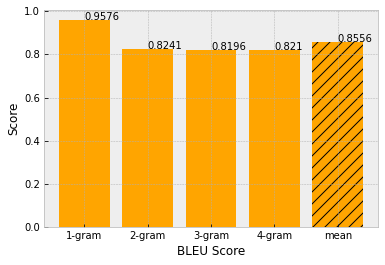

<Figure size 1440x720 with 0 Axes>

In [178]:
plt.style.use('bmh')
plt.xlabel('BLEU Score')
plt.ylabel('Score')
for index, (key, value) in enumerate(bleu_scores.items()):
    if index == len(bleu_scores.values()) - 1:
        plt.bar(index, value, color='orange', hatch='//')
    else:
        plt.bar(index, value, color='orange')
    plt.text(index, value, str(round(value, 4)))
plt.xticks(range(len(bleu_scores)), bleu_scores.keys())
plt.yticks(np.arange(0, 1.03, 0.2))
plt.figure(figsize=(20, 10))
plt.show()

In [72]:
saved_model_path = f"/home/andyalyfsyah/experiment_siet24_288/experiment_105.pth.tar"
checkpoint = torch.load(saved_model_path)
transformer = checkpoint['transformer']

In [73]:
encoded_play = []

words = list(tests['Pertanyaan'])
labels_words = list(tests['Labels'] )

for i in range(len(words)):
    words[i] = words[i].lower()
    question = words[i] 
    max_len = 50
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    if len(enc_qus) < 10:
        left_pad = [word_map['<pad>']] * (10 - len(enc_qus))
        enc_qus = left_pad + enc_qus
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    print()
    print(question)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
    print(question_mask)
    encoded = transformer.encode(question, question_mask)
    print(encoded)
    encoded = encoded.detach().cpu().numpy()
    if encoded.shape[0] > 1:
        concetaned_encoded = np.concatenate(encoded, axis=0)
        encoded = concetaned_encoded
    encoded_play.append(encoded[0].flatten())



tensor([[  0,   0,   0,   0,   0,   0,   0, 104,  62,  28]], device='cuda:0')
tensor([[[[False, False, False, False, False, False, False,  True,  True,  True]]]],
       device='cuda:0')
tensor([[[-0.4308,  1.7268, -3.5057,  ..., -1.0437, -0.1656, -2.3352],
         [ 0.1414,  0.6119, -1.3479,  ..., -0.7701, -0.0793, -2.6979],
         [ 0.7828, -1.3572, -1.7044,  ..., -1.2023, -0.4344, -1.9561],
         ...,
         [ 0.4359,  1.7354, -3.2791,  ..., -0.9037, -0.2538, -1.3264],
         [ 0.2782,  0.3698, -0.4754,  ..., -1.3937, -0.4852, -0.8032],
         [ 0.6412,  0.5493, -1.4470,  ..., -1.2273, -0.6602, -0.6006]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

tensor([[   0,    0,    0,    0,    0,    0,    0,   62,   51, 2546]],
       device='cuda:0')
tensor([[[[False, False, False, False, False, False, False,  True,  True,  True]]]],
       device='cuda:0')
tensor([[[-0.0617,  1.8195, -3.9824,  ..., -0.4691, -0.5702, -1.6658],
         [ 0.8550, -0.0067, -3.452

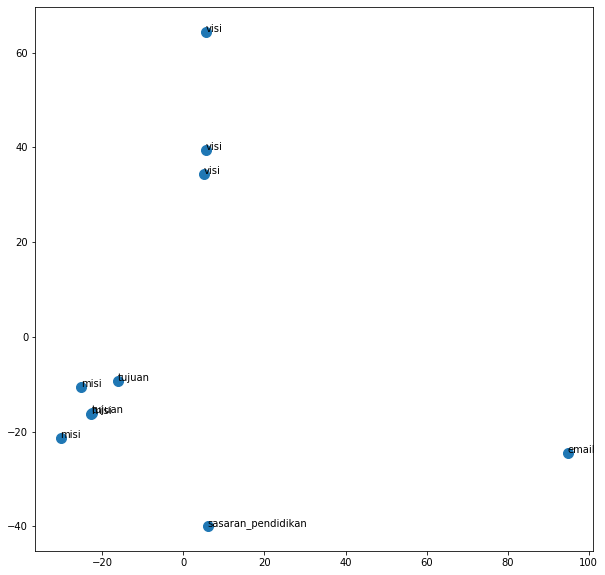

In [74]:
pca = PCA(n_components=2)
encoded_play_pca = pca.fit_transform(encoded_play)

plt.figure(figsize=(10,10))
plt.scatter(encoded_play_pca[:,0], encoded_play_pca[:,1], s=100)
for i, txt in enumerate(labels_words):
    plt.annotate(txt, (encoded_play_pca[i,0], encoded_play_pca[i,1]))

In [49]:
summary(transformer)

Layer (type:depth-idx)                   Param #
Transformer                              --
├─Embeddings: 1-1                        --
│    └─Dropout: 2-1                      --
│    └─Embedding: 2-2                    2,610,176
├─Embeddings: 1-2                        --
│    └─Dropout: 2-3                      --
│    └─Embedding: 2-4                    2,610,176
├─EncoderLayer: 1-3                      --
│    └─LayerNorm: 2-5                    2,048
│    └─MultiHeadAttention: 2-6           --
│    │    └─Dropout: 3-1                 --
│    │    └─Linear: 3-2                  1,049,600
│    │    └─Linear: 3-3                  1,049,600
│    │    └─Linear: 3-4                  1,049,600
│    │    └─Linear: 3-5                  1,049,600
│    └─FeedForward: 2-7                  --
│    │    └─Linear: 3-6                  2,099,200
│    │    └─Linear: 3-7                  2,098,176
│    │    └─Dropout: 3-8                 --
│    └─Dropout: 2-8                      --
├─DecoderLay

In [69]:
saved_model_path = f"/home/andyalyfsyah/experiment_siet24_288/experiment_37.pth.tar"
checkpoint = torch.load(saved_model_path)
transformer = checkpoint['transformer']


In [70]:
encoded_play = []

words = list(tests['Pertanyaan'])
labels_words = list(tests['Labels'] )

for i in range(len(words)):
    words[i] = words[i].lower()
    question = words[i] 
    max_len = 50
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    if len(enc_qus) < 10:
        left_pad = [word_map['<pad>']] * (10 - len(enc_qus))
        enc_qus = left_pad + enc_qus
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    print()
    print(question)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
    print(question_mask)
    encoded = transformer.encode(question, question_mask)
    print(encoded)
    encoded = encoded.detach().cpu().numpy()
    if encoded.shape[0] > 1:
        concetaned_encoded = np.concatenate(encoded, axis=0)
        encoded = concetaned_encoded
    encoded_play.append(encoded[0].flatten())



tensor([[  0,   0,   0,   0,   0,   0,   0, 104,  62,  28]], device='cuda:0')
tensor([[[[False, False, False, False, False, False, False,  True,  True,  True]]]],
       device='cuda:0')
tensor([[[ 0.4176, -0.6113, -0.1019,  ..., -1.2706, -0.0157,  1.6080],
         [-0.4089, -1.2244,  0.2697,  ..., -1.4513,  0.4917,  2.2217],
         [-0.0678, -0.7721, -0.2333,  ..., -1.9323,  0.0137, -0.4056],
         ...,
         [-0.8394, -0.6284, -0.4258,  ..., -0.7151, -1.1960, -1.3372],
         [ 0.4464,  2.0722, -1.3132,  ..., -1.9323, -0.6144,  0.5126],
         [ 1.3352,  1.7453, -1.9330,  ..., -1.1546, -0.2814,  0.8742]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

tensor([[   0,    0,    0,    0,    0,    0,    0,   62,   51, 2546]],
       device='cuda:0')
tensor([[[[False, False, False, False, False, False, False,  True,  True,  True]]]],
       device='cuda:0')
tensor([[[ 0.3516, -0.6032, -0.0806,  ..., -0.7005, -0.0933,  1.5685],
         [ 0.3668, -0.8181,  0.692

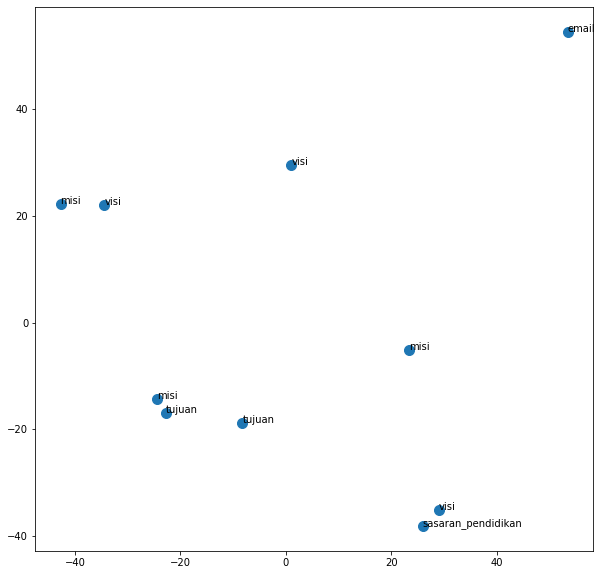

In [71]:
pca = PCA(n_components=2)
encoded_play_pca = pca.fit_transform(encoded_play)

plt.figure(figsize=(10,10))
plt.scatter(encoded_play_pca[:,0], encoded_play_pca[:,1], s=100)
for i, txt in enumerate(labels_words):
    plt.annotate(txt, (encoded_play_pca[i,0], encoded_play_pca[i,1]))

In [53]:
summary(transformer)

Layer (type:depth-idx)                   Param #
Transformer                              --
├─Embeddings: 1-1                        --
│    └─Dropout: 2-1                      --
│    └─Embedding: 2-2                    2,610,176
├─Embeddings: 1-2                        --
│    └─Dropout: 2-3                      --
│    └─Embedding: 2-4                    2,610,176
├─EncoderLayer: 1-3                      --
│    └─LayerNorm: 2-5                    2,048
│    └─MultiHeadAttention: 2-6           --
│    │    └─Dropout: 3-1                 --
│    │    └─Linear: 3-2                  1,049,600
│    │    └─Linear: 3-3                  1,049,600
│    │    └─Linear: 3-4                  1,049,600
│    │    └─Linear: 3-5                  1,049,600
│    └─FeedForward: 2-7                  --
│    │    └─Linear: 3-6                  2,099,200
│    │    └─Linear: 3-7                  2,098,176
│    │    └─Dropout: 3-8                 --
│    └─Dropout: 2-8                      --
├─DecoderLay

# Reset Cache

In [ ]:
import torch

torch.cuda.empty_cache()

print(torch.cuda.memory_summary(device=None, abbreviated=False))